# Exercice 1

In this section, we will present the second part of exercie 1. 



---

## Q4 Resnet Network Architecture

References
* https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
* https://www.bilibili.com/video/BV14E411H7Uw?from=search&seid=7956158567090122970
* He K, Zhang X, Ren S, et al. Deep residual learning for image recognition[C]//Proceedings of the IEEE conference on computer vision and pattern recognition. 2016: 770-778.

Modified by Yan CHEN

The network architecture has 5 types. Its are is 18 layers, 34 layersm 50 layers, 101 layers and 152 layeres. 
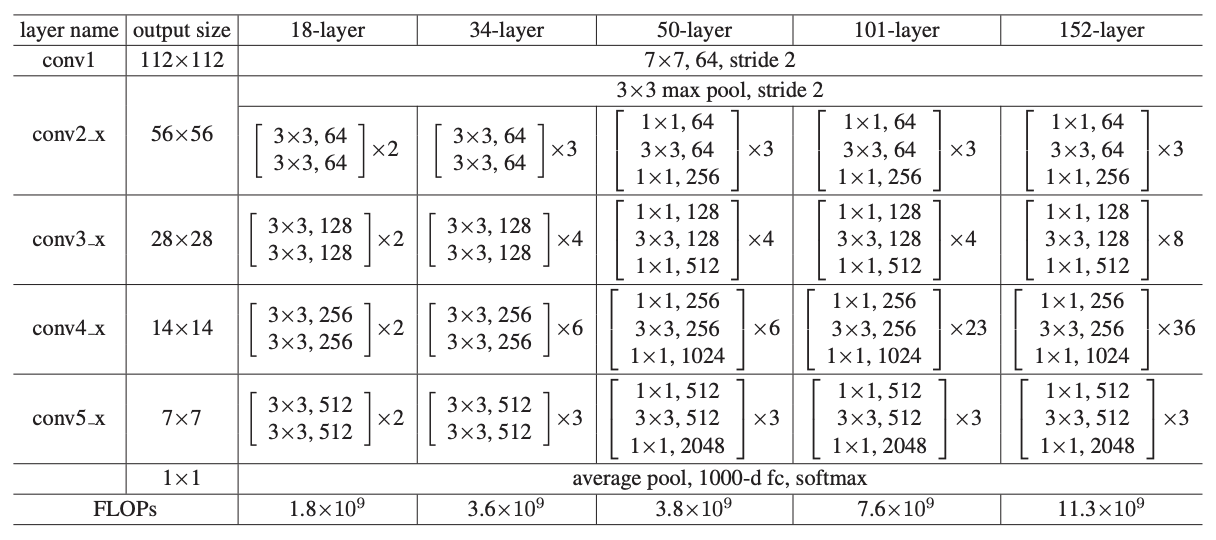

In [ ]:
import torch.nn as nn
import torch

Residual block fof 18 layer and 34 layers.

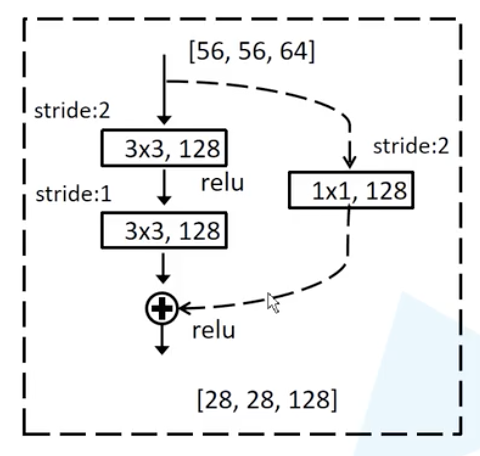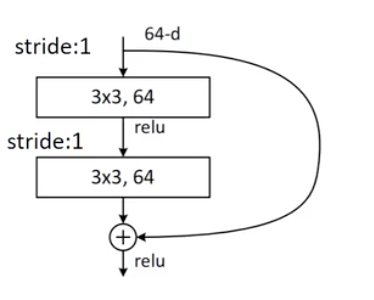

In [ ]:
'''
create a residual block for 18 layer and 34 layers.
After convolution, il is better to normalize the outputs in order to accelerate the training and stabilize the net.
'''
class Residual_Block2(nn.Module):
  expansion = 1
  def __init__(self, input_channel, output_channel, stride=1, downsample=None):
    super(Residual_Block2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=3, stride=stride, padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(output_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=output_channel, out_channels=output_channel,kernel_size=3, stride=1,padding=1,bias=False)
    self.bn2 = nn.BatchNorm2d(output_channel)
    self.downsample= downsample

  def forward(self, x):
    identity = x

    # if depth of residual block's inputs and ouputs are not same. It should downsample
    if self.downsample is not None:
      identity = self.downsample(x)
    
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.conv2(out)
    out += identity # inputs of residual block add their outputs
    out = self.relu(out)
    return out

Residual block for 50 layers, 101 layers and 152 layers.

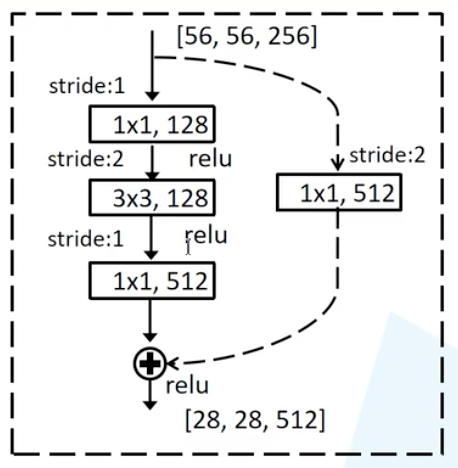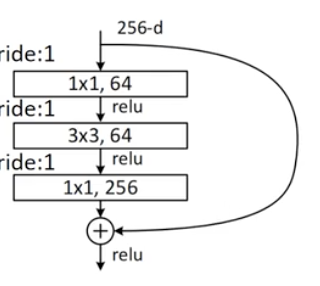

In [ ]:
'''
create a residual bliock for 50 layers, 101 layers and 152 layers
'''
class Residual_Block3(nn.Module):
  expansion = 4

  def __init__(self, input_channel, output_channel, stride=1, downsample=None):
    super(Residual_Block3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=1, stride=1, bias=False)
    self.bn1 = nn.BatchNorm2d(output_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(output_channel)
    self.conv3 = nn.Conv2d(in_channels=output_channel, out_channels=output_channel*self.expansion, kernel_size=1, stride=1, bias=False)
    self.bn3 = nn.BatchNorm2d(output_channel*self.expansion)
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self, x):
    identity = x
    if self.downsample is not None:
      identity = self.downsample(x)

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.conv3(out)
    out = self.bn3(out)
    out += identity
    out = self.relu(x)

    return out


In [ ]:
# create structure of resnet
class ResNet(nn.Module):
  def __init__(self, block, block_num, num_classes=1000):
    super(ResNet, self).__init__()
    self.in_channel = 64
    self.conv1 = nn.Conv2d(in_channels=1 , out_channels=self.in_channel, kernel_size=7, stride=2, padding=3,bias=False)
    self.bn1 = nn.BatchNorm2d(64) # normalization 
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, block_num[0])
    self.layer2 = self._make_layer(block, 128, block_num[1], stride=2)
    self.layer3 = self._make_layer(block, 256, block_num[2], stride=2)
    self.layer4 = self._make_layer(block, 512, block_num[3], stride=2)
    self.average_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

  def _make_layer(self, block, channel, block_num, stride=1):
    downsample = None
    if stride !=1 or self.in_channel != channel*block.expansion:
      downsample = nn.Sequential(nn.Conv2d(in_channels=self.in_channel, out_channels=channel*block.expansion, kernel_size=1, stride=stride, bias=False),
                                 nn.BatchNorm2d(channel*block.expansion))
      
    layers = []
    layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
    self.in_channel = channel*block.expansion

    for _ in range(1, block_num):
      layers.append(block(self.in_channel, channel))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.average_pool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)
    return x

def resnet18(num_classes=1000):
  return ResNet(Residual_Block2, [2,2,2,2], num_classes=num_classes)

def resnet101(num_classes=1000):
  return ResNet(Residual_Block3 [3,4,23,3], num_classes=num_classes)

train the dadaset

In [ ]:
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

Prepare train dataset

In [ ]:
# define tranform methode of dataset
data_tranform = {"train": transforms.Compose([transforms.Resize(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.5],[0.5])]),
                 "test": transforms.Compose([transforms.Resize(224), 
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.5],[0.5])])}

# train dataset
train_dataset = datasets.MNIST(root= './',
                               train = True,
                               transform = data_tranform["train"],
                               download = True)

# test dataset
test_dataset = datasets.MNIST(root= './',
                               train = False,
                               transform = data_tranform["test"],
                               download = True)

# define batch size
batch_size = 64

# load train dataset and divide the train dataset into numbre of batch, each batch has batch size samples
train_loader = DataLoader(dataset=train_dataset,
                          batch_size = batch_size,
                          shuffle = True)
# load test dataset
test_loader = DataLoader(dataset=test_dataset,
                          batch_size = batch_size,
                          shuffle = True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# creat a net (resnet18)
model = resnet18()

#modify the final full connect layer to fit my needs(10 classes)
inchannel = model.fc.in_features
model.fc = nn.Linear(inchannel, 10)

model.to('cuda:0')

# define loss fonction
CE_loss = nn.CrossEntropyLoss()

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay= 0.001)
!nvidia-smi

Sat Dec 12 09:41:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    38W / 300W |   1303MiB / 16130MiB |      4%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def train():
  model.train() # train etat

  for i, data in enumerate(train_loader):
    inputs, labels = data # obtain data and labels of each batch
    out = model(inputs.to('cuda:0'))
    loss = CE_loss(out, labels.to('cuda:0')) # calculate loss
    optimizer.zero_grad() # set gradient 0
    loss.backward() # start backward
    optimizer.step()
  
  # obtain accuracy in train dataset
  correct = 0
  for i, data in enumerate(train_loader):
    inputs, labels = data
    out = model(inputs.to('cuda:0')) # out is one-hot code

    # obtain the maximum value and its' position
    _, prediction = torch.max(out,1)

    # obtain the number of successful prediction 
    correct += (prediction == labels.to('cuda:0')).sum()
  print("Train acc : {}".format(correct.item()/len(train_dataset)))

def test():
  model.eval() # test etat
  correct = 0

  # obtain accuracy in test dataset
  for i, data in enumerate(test_loader):
    inputs, labels = data
    out = model(inputs.to('cuda:0')) 
    _, prediction = torch.max(out,1)
    correct += (prediction == labels.to('cuda:0')).sum()
  print("Test acc : {}".format(correct.item()/len(test_dataset)))

  

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
for epoch in range(10):
  print("epoch : ", epoch)
  train()
  test()

1
Tesla V100-SXM2-16GB
epoch :  0
Train acc : 0.10245
Test acc : 0.1014
epoch :  1
Train acc : 0.09871666666666666
Test acc : 0.098
epoch :  2
Train acc : 0.11188333333333333
Test acc : 0.1134
epoch :  3
Train acc : 0.0993
Test acc : 0.1032
epoch :  4
Train acc : 0.09915
Test acc : 0.1009
epoch :  5
Train acc : 0.09863333333333334
Test acc : 0.0958
epoch :  6
Train acc : 0.11236666666666667
Test acc : 0.1135
epoch :  7
Train acc : 0.10218333333333333
Test acc : 0.101
epoch :  8
Train acc : 0.11236666666666667
Test acc : 0.1135
epoch :  9
Train acc : 0.09915
Test acc : 0.1009




---

## Q5 Hyper-parameter optimization

In this section, we do the research about the inluence of learning rate, weight decay and batch size for accuracy.

The fisrt table is the result of accuracy for different weight decacy and learning rate. And the batch size is 64. We can see that the hightest accuracy is 99.16% for weight decacy = 0.001 and learning rate = 0.001. 
 
 $\lambda$ | 1.0 | 0.1 | 0.01 | 0.001 
---|---|---|---|---
weight decay|
0.1| 0.1135 | 0.1135 | 0.2413 | 0.9717 
0.01| 0.1028 | 0.2685 | 0.9540 | 0.9894 
0.001| 0.1135 | 0.1135 | 0.9783 | 0.9916


The fisrt table is the result of accuracy for different batch size and learning rate. And the weight decacy 0.001. We can see that the hightest accuracy is 99.16% for batch size = 64 and learning rate = 0.001. 

 $\lambda$ | 1.0 | 0.1 | 0.01 | 0.001 
---|---|---|---|---
batch size|
5| 0.1135 | 0.1028 | 0.9476 | 0.9886 
64| 0.11135 | 0.1135 | 0.9783 | 0.9916
200| 0.1135 | 0.1146 | 0.9823 | 0.9908


According to the result as bellow, we can see that the best configution of hyper parameter is weight decacy = 0.001, batch size = 64 and learning rate = 0.001.

In fact, the learning rate affects the accuracy of the prediction as well as the speed of convergence. If the learning rate is too large, it may cause the model parameters to oscillate around the optimal value, which may result in the model not converging properly and reduce the prediction accuracy of the model. If the learning rate is too small, it may cause the model to train too slowly and even converge to a local minimum, reducing the prediction accuracy of the model. 

Batch size affects the speed of convergence and the stability of the model training. The smaller the size, the longer the training time and the less stable the training may be. The larger the batch size, the shorter the training time, which can improve the training stability. However, if the batch size is too small, the model may not converge, and if the size is too large, it will take up a lot of computer memory, but the training time will not be reduced. 

The purpose of weight decacy is to prevent overfitting. In the loss function, the weight decay is a coefficient placed in front of the regularization term, the regularization term generally indicates the complexity of the model, so the role of the weight decay is to regulate the effect of model complexity on the loss function, if the weight decay is large, the value of the loss function of a complex model is also large. And from the results above, it can also slightly improve the accuracy of the model.

So it is very important to find these propriate hyper parameters for the model. It will improve greatly the performance of the model.



---



---


## Q6 Regularization

In this model, we use weigth decacy as coefficient of regularization. Actually, it is L2 regularization or Fobenius rgularization. For example, here is a cost function : 

$J_1 = \frac{1}{m} \sum Loss$

Now we add the L2 regularization term. The cost function is :

$J_2 = J_1 + weight\_decacy * ||W||_{L_2}^2$

Where $W$ is weight parametres

Now backpropation and update weight :

$W = W - \alpha * \frac{dJ}{dW} = W - \alpha * (\frac{dJ_1}{dW} + 2weight\_decacy * W)$

$=> W = (1-2\alpha * weight\_decacy)*W - \alpha \frac{dJ_1}{dW}$

Where $\alpha$ is the learning rate.

Based on the equation above, we can see that the larger the weight decacy, the smaller the $W$, even the value tend to 0. It means that some noeds in the network are will be not activated, which makes the model simpler so that it can prevent overfitting. 